# Dipole radiation in a planar structure
In a planar structure, the dielectric function $\epsilon(\omega,\mathbf{r})$ is spatially only a function of $z$, that is, $\epsilon(\omega,\mathbf{r}) = \epsilon(\omega,z)$ Thus, the system (geometry + materials) has the azimuthal symmetry. We can exploit this property to reduce computation.  
Any $E$-field can be expressed as
$$ \mathbf{E}(r,\phi,z) = \sum_{m=0}^{\infty} \mathbf{E}_m(r,z) e^{i m \phi} $$

In the cylindrical simulation, the computation of the total fields
is splitted into separate computations of theri respective $m$.
In the simulation class, we have to specify $m$. 
For example, the following code takes only fields of $m=-1$ into account.

```python
mp.Simulation(resolution=resolution,
              cell_size=cell_size,
              boundary_layers=pml_layers,
              sources=sources,
              dimensions=mp.CYLINDRICAL,
              m=-1
              )
```
In this case, even if you set  a `source` with contains other $m$'s, the simulation will only compute the component of $m=-1$.

In this simulation, we consider a $x$-dipole at Origin, whose total field contain every $m$ term. However, for the far-field radiation, we only need to consider $m= \pm 1$ (Why? Eq. 9.130 from Jackson. Conceptially, becuase there is only dipole moment). Moreover, because contributions from $m=\pm1$ are equal, we need only the case $m=-1$



In [34]:
import meep as mp
from meep.materials import Al, Ag, Au, SiO2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from time import perf_counter
print(mp.__version__)

## import my colormap
import mycmapls as ms
mycmap = ms.mycmap
mycmap1 = ms.mycmap1
mycmap2 = ms.mycmap2
bicmap = ms.bicmap
##


1.24.0


In [35]:
resolution = 30  # pixels/μm

dpml = 0.5       # thickness of PML
h = 3# height
w = 12
L = 3.0          # length of non-PML region
n = 1          # vaccum refractive index
wvl = 1.0        # wavelength (in vacuum)

fcen = 1/wvl


In [36]:
def bulk_ldos_cyl(m):
    if np.abs(m)>1:
        courant =  1/2/(np.abs(m)+1)
    else:
        courant = 0.5
    
    sr = w+dpml
    sz = h+2*dpml
    cell_size = mp.Vector3(sr,0,sz)

    pml_layers = [mp.PML(dpml)]

    sources = [mp.Source(src=mp.GaussianSource(fcen,fwidth=0.2*fcen),
                         component=mp.Er,
                         center=mp.Vector3(0))]

    sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=pml_layers,
                        sources=sources,
                        dimensions=mp.CYLINDRICAL,
                        m=m,
                        Courant = courant,
                       # accurate_fields_near_cylorigin= True,# we have a dipole at Origin!!
                        default_material=mp.Medium(index=n))

    sim.run(mp.dft_ldos(fcen,0,1),
            until_after_sources=mp.stop_when_fields_decayed(20,
                                                            mp.Er,
                                                            mp.Vector3(),
                                                            1e-6))

    return sim.ldos_data[0]


def cavity_ldos_cyl(sz,m):
    if np.abs(m)>1:
        courant =  1/2/(np.abs(m)+1)
    else:
        courant = 0.5

    sr = w+dpml
    cell_size = mp.Vector3(sr,0,sz)

    pml_layers = [mp.PML(dpml,direction=mp.R)]

    sources = [mp.Source(src=mp.GaussianSource(fcen,fwidth=0.2*fcen),
                         component=mp.Er,
                         center=mp.Vector3())]

    sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=pml_layers,
                        sources=sources,
                        dimensions=mp.CYLINDRICAL,
                        m=m,
                        default_material=mp.Medium(index=n))

    sim.run(mp.dft_ldos(fcen,0,1),
            until_after_sources=mp.stop_when_fields_decayed(20,
                                                            mp.Er,
                                                            mp.Vector3(),
                                                            1e-6))

    return sim.ldos_data[0]


In [51]:
%%capture 
import time
import numpy as np
from joblib import Parallel, delayed
nc = 6 ## number of processes

start = time.time()
##

ldos_bulk_cyl = bulk_ldos_cyl(1)

# units of wavelength in cavity medium
cavity_thickness = np.arange(0.50,2.55,0.05)

gap = cavity_thickness*wvl/n

ldos_cavity_cyl = np.zeros(len(cavity_thickness))

with Parallel(n_jobs=nc) as parallel:
     ldos_cavity_cyl = parallel([delayed(cavity_ldos_cyl)(gap[i], 1) for i in range(len(gap))])

ldos_cavity_cyl = np.array(ldos_cavity_cyl)

# for idx,g in enumerate(gap):
#     ldos_cavity_cyl[idx] = cavity_ldos_cyl(g,1)

# Purcell enhancement factor (relative to bulk medium)
pe_meep_cyl = ldos_cavity_cyl / ldos_bulk_cyl


# equation 7 of reference
pe_theory = (3*np.fix(cavity_thickness+0.5)/(4*cavity_thickness) +
             (4*np.power(np.fix(cavity_thickness+0.5),3) -
              np.fix(cavity_thickness+0.5)) /
             (16*np.power(cavity_thickness,3)))
##
end = time.time()

-----------
Initializing structure...
time for choose_chunkdivision = 4.50611e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 0.5 with resolution 30
time for set_epsilon = 0.00801301 s
-----------
-----------
Initializing structure...
time for choose_chunkdivision = 4.19617e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 0.666667 with resolution 30
-----------
Initializing structure...
time for choose_chunkdivision = 4.29153e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 0.6 with resolution 30
-----------
Initializing structure...
time for choose_chunkdivision = 4.3869e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 0.566667 with resolution 30
time for set_epsilon = 0.011061 s
-----------
time for set_epsilon = 0.0129511 s
-----------
time for set_epsilon = 0.0150931 s
-----------
-----------
Initializing structure...
time for choose_chunkdivision = 4.41074e-05 s
Working in Cylindri

Meep: using complex fields.
field decay(t = 20.016666666666666): 25.11227803177538 / 25.11227803177538 = 1.0
field decay(t = 40.03333333333333): 67.48852157431324 / 67.48852157431324 = 1.0
field decay(t = 60.05): 0.007752118786614521 / 67.48852157431324 = 0.00011486573725101498
field decay(t = 80.05): 1.4453748668864296e-06 / 67.48852157431324 = 2.1416602900315315e-08
ldos0:, 1.0, 0.29682867643245875
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.1008e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 0.8 with resolution 30
time for set_epsilon = 0.01492 s
-----------
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.0015076997424 / 25.0015076997424 = 1.0
field decay(t = 40.03333333333333): 67.17204680935038 / 67.17204680935038 = 1.0
field decay(t = 60.05): 0.0077253418487828185 / 67.17204680935038 = 0.00011500828418566885
field decay(t = 80.05): 1.912150094314099e-06 / 67.172

Meep: using complex fields.
field decay(t = 20.016666666666666): 25.217207637899506 / 25.217207637899506 = 1.0
field decay(t = 40.03333333333333): 67.78387982977075 / 67.78387982977075 = 1.0
field decay(t = 60.05): 0.007783624961403565 / 67.78387982977075 = 0.00011483003010377975
field decay(t = 80.05): 8.043592262930255e-07 / 67.78387982977075 = 1.1866526795353931e-08
ldos0:, 1.0, 0.24233119617368887
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.19617e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 0.9 with resolution 30
time for set_epsilon = 0.0173521 s
-----------
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.240013019759566 / 25.240013019759566 = 1.0
field decay(t = 40.03333333333333): 67.8496058431502 / 67.8496058431502 = 1.0
field decay(t = 60.05): 0.007792002020915598 / 67.8496058431502 = 0.00011484225920086528
field decay(t = 80.05): 5.506900655978443e-07 / 67

Meep: using complex fields.
field decay(t = 20.016666666666666): 25.26391652320426 / 25.26391652320426 = 1.0
field decay(t = 40.03333333333333): 67.92005289881398 / 67.92005289881398 = 1.0
field decay(t = 60.05): 0.007801806006101049 / 67.92005289881398 = 0.00011486749013172933
field decay(t = 80.05): 2.521083274237257e-07 / 67.92005289881398 = 3.71183938562757e-09
ldos0:, 1.0, 0.19326473072216416
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.48227e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1 with resolution 30
time for set_epsilon = 0.018379 s
-----------


Meep: using complex fields.
field decay(t = 20.016666666666666): 24.54460120292275 / 24.54460120292275 = 1.0
field decay(t = 40.03333333333333): 65.24964839560825 / 65.24964839560825 = 1.0
field decay(t = 60.05): 0.0014113502110201187 / 65.24964839560825 = 2.163000484635734e-05
field decay(t = 80.05): 0.00035625253939566457 / 65.24964839560825 = 5.459838453622117e-06
field decay(t = 100.06666666666666): 0.00014207116212668067 / 65.24964839560825 = 2.177347550829761e-06
field decay(t = 120.08333333333333): 7.4385946685451e-05 / 65.24964839560825 = 1.1400206516738517e-06
field decay(t = 140.1): 5.480131616198466e-05 / 65.24964839560825 = 8.398714400685287e-07
ldos0:, 1.0, 0.3292514546240703
run 0 finished at t = 140.1 (8406 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.69685e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1.06667 with resolution 30
time for set_epsilon = 0.0213528 s
-----------


Meep: using complex fields.
field decay(t = 20.016666666666666): 25.270364700405047 / 25.270364700405047 = 1.0
field decay(t = 40.03333333333333): 67.93978625967927 / 67.93978625967927 = 1.0
field decay(t = 60.05): 0.007803814511003037 / 67.93978625967927 = 0.00011486368946136096
field decay(t = 80.05): 1.6533339987014658e-07 / 67.93978625967927 = 2.4335284076139083e-09
ldos0:, 1.0, 0.17907398552267573
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.19753e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1.1 with resolution 30
time for set_epsilon = 0.0195088 s
-----------


Meep: using complex fields.
field decay(t = 20.016666666666666): 25.269354309793414 / 25.269354309793414 = 1.0
field decay(t = 40.03333333333333): 67.94136735756346 / 67.94136735756346 = 1.0
field decay(t = 60.05): 0.00780693316024285 / 67.94136735756346 = 0.00011490691847805085
field decay(t = 80.05): 1.208233036645245e-07 / 67.94136735756346 = 1.7783466592400576e-09
ldos0:, 1.0, 0.15848458317649194
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1.16667 with resolution 30
time for set_epsilon = 0.0211871 s
-----------


Meep: using complex fields.
field decay(t = 20.016666666666666): 25.26285474722543 / 25.26285474722543 = 1.0
field decay(t = 40.03333333333333): 67.92540568456866 / 67.92540568456866 = 1.0
field decay(t = 60.05): 0.007804870003772294 / 67.92540568456866 = 0.00011490354639936158
field decay(t = 80.05): 6.762423182691678e-08 / 67.92540568456866 = 9.955661088127987e-10
ldos0:, 1.0, 0.15027767695135089
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.19753e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1.2 with resolution 30
time for set_epsilon = 0.0225101 s
-----------


Meep: using complex fields.
field decay(t = 20.016666666666666): 25.2509896657967 / 25.2509896657967 = 1.0
field decay(t = 40.03333333333333): 67.89350385394751 / 67.89350385394751 = 1.0
field decay(t = 60.05): 0.007832602879959648 / 67.89350385394751 = 0.00011536601346734353
field decay(t = 80.05): 5.6824690583088866e-08 / 67.89350385394751 = 8.369680066200461e-10
ldos0:, 1.0, 0.13485924731417567
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.19888e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1.26667 with resolution 30
time for set_epsilon = 0.021842 s
-----------


Meep: using complex fields.
field decay(t = 20.016666666666666): 25.246896817931134 / 25.246896817931134 = 1.0
field decay(t = 40.03333333333333): 67.88720373281018 / 67.88720373281018 = 1.0
field decay(t = 60.05): 0.0078028409843129976 / 67.88720373281018 = 0.00011493831761024281
field decay(t = 80.05): 3.1607530913351084e-08 / 67.88720373281018 = 4.655889354016069e-10
ldos0:, 1.0, 0.12885932756270385
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.29153e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1.3 with resolution 30
time for set_epsilon = 0.022567 s
-----------
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.229645496311 / 25.229645496311 = 1.0
field decay(t = 40.03333333333333): 67.84295132237568 / 67.84295132237568 = 1.0
field decay(t = 60.05): 0.007801300932573094 / 67.84295132237568 = 0.0001149905890075879
on time step 4360 (time=72.6667), 0.00091756 s/step


field decay(t = 80.05): 3.705417854027903e-08 / 67.84295132237568 = 5.461758048261378e-10
ldos0:, 1.0, 0.11901200865146884
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.4121e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1.36667 with resolution 30
time for set_epsilon = 0.0258369 s
-----------
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.219457703234863 / 25.219457703234863 = 1.0
field decay(t = 40.03333333333333): 67.81583415376906 / 67.81583415376906 = 1.0
field decay(t = 60.05): 0.007800359457647568 / 67.81583415376906 = 0.00011502268688401941
on time step 3920 (time=65.3333), 0.00102069 s/step
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.19824232528585 / 25.19824232528585 = 1.0
field decay(t = 40.03333333333333): 67.75999747120032 / 67.75999747120032 = 1.0
on time step 3564 (time=59.4), 0.00112254 s/step
Meep: using complex fields.
field de

Meep: using complex fields.
field decay(t = 20.016666666666666): 25.156827371154197 / 25.156827371154197 = 1.0
field decay(t = 40.03333333333333): 67.64723488599465 / 67.64723488599465 = 1.0
on time step 3080 (time=51.3333), 0.00129896 s/step
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.14126901671885 / 25.14126901671885 = 1.0
field decay(t = 40.03333333333333): 67.60281128928732 / 67.60281128928732 = 1.0
on time step 2934 (time=48.9), 0.00136398 s/step
field decay(t = 60.05): 0.007793260439583067 / 67.75999747120032 = 0.00011501270263322244
field decay(t = 80.05): 2.176350985069399e-08 / 67.75999747120032 = 3.2118522229792026e-10
ldos0:, 1.0, 0.10545708143293114
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.00679e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1.46667 with resolution 30
time for set_epsilon = 0.0292289 s
-----------


field decay(t = 60.05): 0.007789582476488261 / 67.72567652284373 = 0.00011501668017831983
field decay(t = 80.05): 2.1157546691214216e-08 / 67.72567652284373 = 3.1240066954632516e-10
ldos0:, 1.0, 0.1008945930539196
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.88622e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1.5 with resolution 30
time for set_epsilon = 0.0266421 s
-----------
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.10028176238265 / 25.10028176238265 = 1.0
field decay(t = 40.03333333333333): 67.47271197907254 / 67.47271197907254 = 1.0
on time step 2725 (time=45.4167), 0.00146844 s/step


field decay(t = 60.05): 0.0077852161224075105 / 67.64723488599465 = 0.00011508550401990375
field decay(t = 80.05): 2.253334414498869e-08 / 67.64723488599465 = 3.331007421510126e-10
ldos0:, 1.0, 0.09479564633016316
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1.56667 with resolution 30
time for set_epsilon = 0.024868 s
-----------


field decay(t = 60.05): 0.007783977447558414 / 67.60281128928732 = 0.00011514280692039655
field decay(t = 80.05): 2.317008368817633e-08 / 67.60281128928732 = 3.4273846377521847e-10
ldos0:, 1.0, 0.09250258427358965
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 7.89165e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1.6 with resolution 30
time for set_epsilon = 0.0336392 s
-----------


Meep: using complex fields.
field decay(t = 20.016666666666666): 25.07431750422638 / 25.07431750422638 = 1.0
field decay(t = 40.03333333333333): 67.36318293403816 / 67.36318293403816 = 1.0
on time step 2447 (time=40.7833), 0.00163484 s/step
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.039192153720197 / 25.039192153720197 = 1.0
on time step 2298 (time=38.3), 0.00174115 s/step
field decay(t = 60.05): 0.007790989259802317 / 67.47271197907254 = 0.00011546874330794327
field decay(t = 80.05): 3.5679401864238625e-08 / 67.47271197907254 = 5.28797506691372e-10
ldos0:, 1.0, 0.08654083341852846
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1.66667 with resolution 30


time for set_epsilon = 0.0315681 s
-----------
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.044808175388038 / 25.044808175388038 = 1.0
on time step 2233 (time=37.2167), 0.00179268 s/step
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.090257791945593 / 25.090257791945593 = 1.0
on time step 2063 (time=34.3833), 0.00193956 s/step
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.116061338962506 / 25.116061338962506 = 1.0
on time step 2039 (time=33.9833), 0.00196187 s/step
field decay(t = 60.05): 0.007563586632573391 / 67.36318293403816 = 0.00011228071927627935
on time step 4736 (time=78.9333), 0.00174816 s/step
field decay(t = 80.05): 6.174758602405801e-07 / 67.36318293403816 = 9.166370016173535e-09
ldos0:, 1.0, 0.08330297701314945
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.00815e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1.

field decay(t = 40.03333333333333): 67.09996001265519 / 67.09996001265519 = 1.0
field decay(t = 60.05): 0.00834452431168522 / 67.09996001265519 = 0.00012435960185537258
on time step 4562 (time=76.0333), 0.00176756 s/step
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.156194506354808 / 25.156194506354808 = 1.0
on time step 1908 (time=31.8), 0.00209656 s/step
field decay(t = 80.05): 2.9428309619237648e-05 / 67.09996001265519 = 4.3857417521094513e-07
ldos0:, 1.0, 0.08152161894358134
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.88894e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1.76667 with resolution 30


time for set_epsilon = 0.0318308 s
-----------
field decay(t = 40.03333333333333): 67.09089663986124 / 67.09089663986124 = 1.0
field decay(t = 60.05): 0.005096674983656372 / 67.09089663986124 = 7.596671439666294e-05
on time step 4450 (time=74.1667), 0.00180449 s/step


field decay(t = 80.05): 3.9670398036412774e-05 / 67.09089663986124 = 5.912933053996939e-07
ldos0:, 1.0, 0.1661800855308791
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 9.70364e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1.8 with resolution 30
time for set_epsilon = 0.027564 s
-----------
field decay(t = 40.03333333333333): 67.34404698730421 / 67.34404698730421 = 1.0
field decay(t = 60.05): 0.00851368360685449 / 67.34404698730421 = 0.00012642073037962063
on time step 4242 (time=70.7), 0.00183622 s/step
field decay(t = 40.03333333333333): 67.46994055233513 / 67.46994055233513 = 1.0
field decay(t = 60.05): 0.0076274463419426205 / 67.46994055233513 = 0.00011304954887319275
on time step 4229 (time=70.4833), 0.00182669 s/step
field decay(t = 80.05): 4.528201894939358e-06 / 67.34404698730421 = 6.723982441674497e-08
ldos0:, 1.0, 0.1998312542032852
run 0 finished at t = 80.05 (4803 timesteps)
---

Meep: using complex fields.
field decay(t = 20.016666666666666): 25.16921486515239 / 25.16921486515239 = 1.0
on time step 2082 (time=34.7), 0.00192217 s/step


field decay(t = 80.05): 5.522356957141589e-07 / 67.46994055233513 = 8.184914514424395e-09
ldos0:, 1.0, 0.19330842352678648
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.98431e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1.9 with resolution 30
time for set_epsilon = 0.0346031 s
-----------
field decay(t = 40.03333333333333): 67.62140135948246 / 67.62140135948246 = 1.0
field decay(t = 60.05): 0.007780850187505483 / 67.62140135948246 = 0.00011506490594806912
on time step 4025 (time=67.0833), 0.00188955 s/step
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.1860257310839 / 25.1860257310839 = 1.0
on time step 2041 (time=34.0167), 0.00196098 s/step
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.191820518493664 / 25.191820518493664 = 1.0
on time step 2016 (time=33.6), 0.00198473 s/step


field decay(t = 80.05): 2.8300256397265737e-07 / 67.62140135948246 = 4.185103506923586e-09
ldos0:, 1.0, 0.18097726139197717
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1.96667 with resolution 30
time for set_epsilon = 0.0298698 s
-----------
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.19734329299597 / 25.19734329299597 = 1.0
on time step 1901 (time=31.6833), 0.0021046 s/step
field decay(t = 40.03333333333333): 67.66297290808646 / 67.66297290808646 = 1.0
field decay(t = 60.05): 0.0077782661040428 / 67.66297290808646 = 0.00011495602054921256
on time step 4236 (time=70.6), 0.00185782 s/step
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.197047540426922 / 25.197047540426922 = 1.0
on time step 1824 (time=30.4), 0.00219304 s/step
field decay(t = 40.03333333333333): 67.71399019695627 / 67.713990196

field decay(t = 40.03333333333333): 67.73126733583331 / 67.73126733583331 = 1.0
field decay(t = 60.05): 0.007785577722509704 / 67.73126733583331 = 0.00011494805912764509
on time step 3844 (time=64.0667), 0.00218899 s/step
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.195849942082745 / 25.195849942082745 = 1.0
on time step 1591 (time=26.5167), 0.00251418 s/step
field decay(t = 80.05): 2.1818488215079745e-07 / 67.71399019695627 = 3.2221536718804203e-09
ldos0:, 1.0, 0.16328308617351078
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.88758e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 2.06667 with resolution 30
time for set_epsilon = 0.0412989 s
-----------


field decay(t = 40.03333333333333): 67.74854500117719 / 67.74854500117719 = 1.0
on time step 3537 (time=58.95), 0.00244618 s/step
field decay(t = 80.05): 2.259352367567816e-07 / 67.73126733583331 = 3.3357597701003044e-09
ldos0:, 1.0, 0.16106935907043157
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.69685e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 2.1 with resolution 30
time for set_epsilon = 0.0419052 s
-----------
field decay(t = 40.03333333333333): 67.74764019020022 / 67.74764019020022 = 1.0
on time step 3451 (time=57.5167), 0.00245956 s/step


Meep: using complex fields.
field decay(t = 20.016666666666666): 25.195175686765047 / 25.195175686765047 = 1.0
on time step 1556 (time=25.9333), 0.00257088 s/step
field decay(t = 40.03333333333333): 67.74474137577484 / 67.74474137577484 = 1.0
on time step 3183 (time=53.05), 0.00251375 s/step
field decay(t = 60.05): 0.007788208135452936 / 67.74854500117719 = 0.00011495757045878415
field decay(t = 80.05): 1.6643121124462691e-07 / 67.74854500117719 = 2.456602001441286e-09
ldos0:, 1.0, 0.1521321916384023
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 8.51154e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 2.16667 with resolution 30
time for set_epsilon = 0.036629 s
-----------


Meep: using complex fields.
field decay(t = 20.016666666666666): 25.18924060536324 / 25.18924060536324 = 1.0
on time step 1540 (time=25.6667), 0.00259879 s/step
field decay(t = 60.05): 0.007792227589098818 / 67.74764019020022 = 0.00011501843558273449
field decay(t = 80.05): 1.3933695216052027e-07 / 67.74764019020022 = 2.0567056176323547e-09
ldos0:, 1.0, 0.14603434890139044
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.79493e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 2.2 with resolution 30
time for set_epsilon = 0.0418282 s
-----------


Meep: using complex fields.
field decay(t = 20.016666666666666): 25.1847796691902 / 25.1847796691902 = 1.0
on time step 1487 (time=24.7833), 0.00269002 s/step
field decay(t = 40.03333333333333): 67.74547900172225 / 67.74547900172225 = 1.0
on time step 3094 (time=51.5667), 0.00260124 s/step
field decay(t = 60.05): 0.007783693393383218 / 67.74474137577484 = 0.00011489738148393944
on time step 4758 (time=79.3), 0.00253973 s/step
field decay(t = 80.05): 1.7474803320142378e-07 / 67.74474137577484 = 2.5795069794732846e-09
ldos0:, 1.0, 0.1391964546186059
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.31673e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 2.26667 with resolution 30


time for set_epsilon = 0.054239 s
-----------
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.175010761801417 / 25.175010761801417 = 1.0
on time step 1427 (time=23.7833), 0.0028039 s/step
field decay(t = 40.03333333333333): 67.73003092579167 / 67.73003092579167 = 1.0
on time step 3013 (time=50.2167), 0.00271567 s/step
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.168823382986968 / 25.168823382986968 = 1.0
on time step 1434 (time=23.9), 0.00278998 s/step
field decay(t = 40.03333333333333): 67.71724508409957 / 67.71724508409957 = 1.0
on time step 3028 (time=50.4667), 0.0025972 s/step
field decay(t = 60.05): 0.007791266025912967 / 67.74547900172225 = 0.00011500791109196963
on time step 4714 (time=78.5667), 0.00246965 s/step


field decay(t = 80.05): 1.3074263689398695e-07 / 67.74547900172225 = 1.9299094023774364e-09
ldos0:, 1.0, 0.13590345649793503
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.00679e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 2.3 with resolution 30
time for set_epsilon = 0.044832 s
-----------
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.153888270283442 / 25.153888270283442 = 1.0
on time step 1450 (time=24.1667), 0.00275948 s/step
field decay(t = 40.03333333333333): 67.69049095711983 / 67.69049095711983 = 1.0
on time step 2928 (time=48.8), 0.00266738 s/step
field decay(t = 60.05): 0.007791449110192319 / 67.73003092579167 = 0.0001150368456014587
on time step 4565 (time=76.0833), 0.00257793 s/step


field decay(t = 80.05): 1.0392637687621865e-07 / 67.73003092579167 = 1.5344209275511105e-09
ldos0:, 1.0, 0.12963318301567983
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.38826e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 2.36667 with resolution 30
time for set_epsilon = 0.0414982 s
-----------
field decay(t = 40.03333333333333): 67.67275117724863 / 67.67275117724863 = 1.0
on time step 2888 (time=48.1333), 0.00275255 s/step
field decay(t = 60.05): 0.0077938114240520984 / 67.71724508409957 = 0.0001150934509277923
on time step 4555 (time=75.9167), 0.00262045 s/step


field decay(t = 80.05): 7.89056385354651e-08 / 67.71724508409957 = 1.1652222183207603e-09
ldos0:, 1.0, 0.12693363321772602
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.79221e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 2.4 with resolution 30
time for set_epsilon = 0.0486231 s
-----------
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.145749085770273 / 25.145749085770273 = 1.0
on time step 1326 (time=22.1), 0.00301724 s/step
field decay(t = 40.03333333333333): 67.62524465804556 / 67.62524465804556 = 1.0
on time step 2864 (time=47.7333), 0.0028289 s/step
field decay(t = 60.05): 0.00778942161258472 / 67.69049095711983 = 0.00011507408946877216
on time step 4442 (time=74.0333), 0.00264346 s/step
Meep: using complex fields.
field decay(t = 20.016666666666666): 25.12784814738816 / 25.12784814738816 = 1.0
on time step 1320 (time=22), 0.00303083 s/step
field decay(t = 80.05)

Meep: using complex fields.
field decay(t = 20.016666666666666): 25.11938727990925 / 25.11938727990925 = 1.0
on time step 1259 (time=20.9833), 0.00317824 s/step
field decay(t = 40.03333333333333): 67.5943642459822 / 67.5943642459822 = 1.0
on time step 2584 (time=43.0667), 0.0031809 s/step
field decay(t = 80.05): 5.767615621489388e-08 / 67.67275117724863 = 8.52280352306475e-10
ldos0:, 1.0, 0.11821493873513775
run 0 finished at t = 80.05 (4803 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.38826e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 2.5 with resolution 30


time for set_epsilon = 0.0689001 s
-----------
field decay(t = 60.05): 0.007794951718262997 / 67.62524465804556 = 0.00011526689119838342
on time step 4049 (time=67.4833), 0.00337618 s/step
field decay(t = 40.03333333333333): 67.50445159049032 / 67.50445159049032 = 1.0
on time step 2420 (time=40.3333), 0.00363797 s/step
Meep: using complex fields.
on time step 1016 (time=16.9333), 0.00393933 s/step
on time step 2348 (time=39.1333), 0.00367478 s/step
field decay(t = 60.05): 0.007766044107253323 / 67.5943642459822 = 0.00011489188771702864
on time step 3726 (time=62.1), 0.00350486 s/step
Meep: using complex fields.
on time step 1022 (time=17.0333), 0.00391592 s/step
field decay(t = 60.05): 0.007834240117158976 / 67.50445159049032 = 0.00011605516277185227
on time step 3646 (time=60.7667), 0.00326372 s/step
field decay(t = 20.016666666666666): 25.112166328124687 / 25.112166328124687 = 1.0
on time step 2190 (time=36.5), 0.0034083 s/step
field decay(t = 40.03333333333333): 67.4478615874678 / 6

69.42977118492126


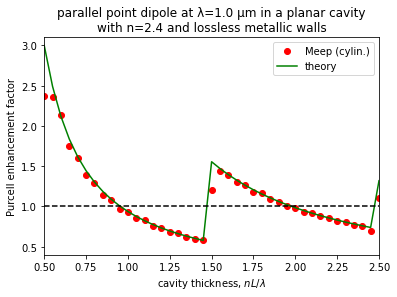

field decay(t = 80.05): 3.590153053966223e-08 / 67.62524465804556 = 5.308894736159882e-10
ldos0:, 1.0, 0.11369815722932092
run 0 finished at t = 80.05 (4803 timesteps)

Elapsed run time = 351.1706 s
field decay(t = 80.05): 8.365562715093823e-08 / 67.5943642459822 = 1.2376124560696745e-09
ldos0:, 1.0, 0.11213392224337763
run 0 finished at t = 80.05 (4803 timesteps)

Elapsed run time = 354.5030 s
field decay(t = 80.05): 9.258654117533001e-07 / 67.50445159049032 = 1.3715620080435276e-08
ldos0:, 1.0, 0.10740237228178162
run 0 finished at t = 80.05 (4803 timesteps)

Elapsed run time = 356.4670 s
field decay(t = 80.05): 4.126166573991176e-06 / 67.4478615874678 = 6.117564703871712e-08
ldos0:, 1.0, 0.10490955121719629
run 0 finished at t = 80.05 (4803 timesteps)

Elapsed run time = 357.2653 s
field decay(t = 80.05): 1.3094277839236342e-05 / 67.37395890349516 = 1.9435221044368598e-07
ldos0:, 1.0, 0.09724522605928315
run 0 finished at t = 80.05 (4803 timesteps)

Elapsed run time = 358.7511 s
fie

In [52]:
execution_time = (end - start)
print(execution_time)
plt.plot(cavity_thickness,pe_meep_cyl,'ro',label='Meep (cylin.)')
plt.plot(cavity_thickness,pe_theory,'g-',label='theory')
plt.plot(cavity_thickness,np.ones(len(cavity_thickness)),'k--')
plt.xlabel('cavity thickness, $nL/\lambda$')
plt.ylabel('Purcell enhancement factor')
plt.title("parallel point dipole at λ=1.0 μm in a planar cavity\n"
          "with n=2.4 and lossless metallic walls")
plt.axis([0.5,2.5,0.4,3.1])
plt.legend()
plt.savefig('cavity_purcell_factor_vs_thickness.png',
            bbox_inches='tight')

In [11]:
sr = w+dpml
sz = h+2*dpml
cell_size = mp.Vector3(sr,0,1)
g = 1
resolution = 70
geometry = []
pml_layers = [mp.PML(dpml,direction=mp.R)]

sources = [mp.Source(src=mp.GaussianSource(fcen,fwidth=0.2*fcen),
                     component=mp.Er,
                     center=mp.Vector3(0))]

sim = mp.Simulation(
                    resolution=resolution,
                    cell_size=cell_size,
                    geometry=geometry,
                    boundary_layers=pml_layers,
                    sources=sources,
                    dimensions=mp.CYLINDRICAL,
                    m=1,
                    default_material=mp.Medium(index=n))
sim.restart_fields()    
sim.run( until=25)
# sim.run( until_after_sources=mp.stop_when_fields_decayed(5,
#                                                             mp.Er,
#                                                             mp.Vector3(),
#                                                             1e-6))

-----------
Initializing structure...
time for choose_chunkdivision = 9.29832e-05 s
Working in Cylindrical dimensions.
Computational cell is 12.5 x 0 x 1 with resolution 70
time for set_epsilon = 0.073617 s
-----------
Meep: using complex fields.
Meep progress: 14.299999999999999/25.0 = 57.2% done in 4.0s, 3.0s to go
on time step 2002 (time=14.3), 0.0019982 s/step
run 0 finished at t = 25.0 (3500 timesteps)


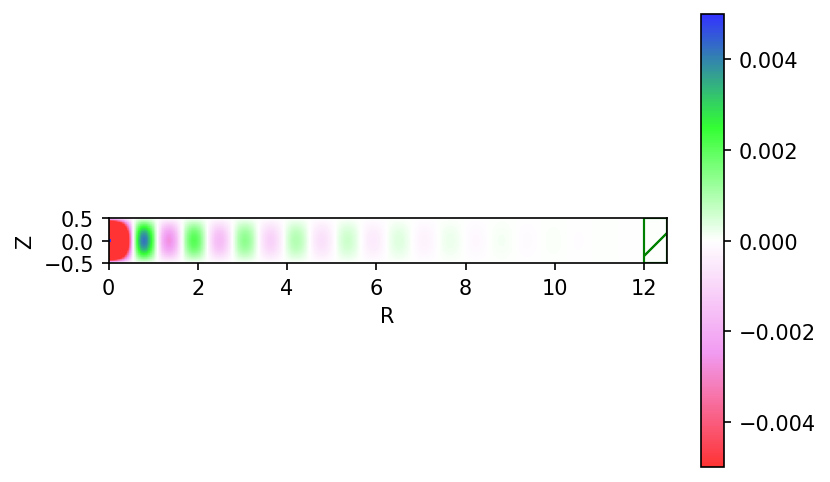

In [21]:

Er = sim.get_array(component=mp.Er, vol=mp.Volume(center=mp.Vector3(sr/2,0,0), size=mp.Vector3(sr,0,1)))
##

nz = Er.shape[0]
nr = Er.shape[1]
zv = np.linspace(-1/2,1/2,nz)
rv = np.linspace(0,sr,nr)
rr, zz = np.meshgrid(rv, zv)
plt.figure(dpi=150)
plt.pcolormesh(rr,zz,np.real(Er), cmap=bicmap,alpha= 0.8)
plt.colorbar()
sim.plot2D(eps_parameters={'contour':False},source_parameters={'alpha':0,'color':'white','linewidth':0.5})
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0,sr)
#plt.ylim(-sz/2,sz/2)
plt.clim(-0.005,0.005)
plt.show()